In [1]:
import numpy as np
from scipy.ndimage import map_coordinates
from typing import Tuple, List
import cv2
import matplotlib.pyplot as plt
import time
import math

- In the above function  the small `u,v` represents the coordinates in the tangential projected viewport `uv` and the capital `U,V` represents the coordinates in the ERP image.

- We orient the viewport as if it were a tangent to a sphere at the north pole, but at a distance `f` from the center of the sphere.

- In the panorama-to-plane conversion process, a key-step involves calculating the focal length, `f` which is derived from the field of view `FOV`, and the width of the output image, `W` . The focal length is crucial because it determines the perspective scale of the image priojection from spherical to a flat plane. 

- To find the focal length we use an empirical formula that takes the half-width of the output image and divides it by the tangent of half the field of view (converted to radians).

- Once we have the Cartesian coordinates, we pass them to the map_to_sphere function along with the yaw and the pitch angles converted to radians. This function will map our Cartesian coordinates `(x, y, z)` onto the sphere, returning the spherical coordinates `(theta, phi)`. This mapping is akin to projecting the flat image onto a sphere, and we’ll use these spherical coordinates to sample the correct pixels from the original panoramic image. 

- This would be an essential step in converting a panorama into a standard view because it allows us to consider the perspective and distortion that comes from viewing a spherical image in a rectangular frame `(the infamous ERP)`. 

- The resulting angles theta and phi will be used to find the corresponding points on the original panoramic image that we need to sample to construct our output image

- Intuitively, we know that the point height will be proportional to the theta  and the width will be proportional to phi  thus we have `U = phi x erp_width/ 2*pi`, `V = theta x erp_height / pi`


# Beta Code for Tangent Projector Re-Orient

### Explanation of the Code

This script demonstrates the integration and testing of a tangential projection method within a 360-degree object tracking system. Below is a breakdown of the key components and their functions:

#### 1. **Clip Box Function**
The `clip_box` function ensures that a bounding box stays within the image dimensions. The box coordinates are adjusted based on the image shape and an optional margin parameter.

#### 2. **TangentialProjector Class**
The `TangentialProjector` class is designed to perform tangent plane projections of a specified region in an equirectangular panorama (ERP) image. This is particularly useful for processing 360-degree videos where object tracking requires re-projection onto a 2D plane.

- **Initialization**: 
  The class is initialized with parameters such as the ERP image, bounding box coordinates, field of view (FOV), and output size. The class calculates the necessary yaw and pitch angles for the projection based on the bounding box location and a given direction (`centre`, `left`, or `right`).

- **Projection Parameters Calculation**:
  The `_calculate_projection_params` method computes the yaw and pitch angles required to orient the tangent plane to the appropriate area of the 360-degree image. This is influenced by the location of the bounding box and the specified direction.

- **Mapping to Sphere**:
  The `_map_to_sphere` method converts 2D coordinates from the tangent plane into spherical coordinates, which is essential for re-projecting the image data back into a 360-degree format.

- **Color Interpolation**:
  The `_interpolate_color` method performs color interpolation on the re-projected image, allowing for smoother transitions and accurate color representation.

- **Projection**:
  The `project` method generates a 2D image from the specified region of the ERP image by mapping it onto a tangent plane. The method uses spherical coordinates to accurately depict the region in the tangent plane.

- **Inverse Projection**:
  The `inverse_project` method allows for the conversion of 2D plane coordinates back into the ERP format. This is useful for mapping detected bounding boxes in the tangent plane back to the 360-degree image.

#### 3. **Usage Example**

- **Bounding Box Setup**:
  The script begins by defining a bounding box in the ERP image. This box represents the area of interest, which will be projected onto the tangent plane.

- **Direction Calculation**:
  A check is performed to see if the bounding box is near the edges of the image. Depending on the proximity, the direction (`left`, `right`, or `centre`) is set to adjust the projection accordingly.

- **Projection Execution**:
  The script creates a `TangentialProjector` object and uses it to generate the tangent plane image. The bounding box is then re-projected from the tangent plane back to the ERP format, demonstrating the process of tracking objects across 360-degree video frames.

- **Visualization**:
  Finally, the script visualizes the original ERP image with the bounding box, the projected 2D tangent plane image, and the re-projected bounding box on the ERP image.

This notebook provides a complete workflow for testing and debugging the tangent projection method in the AiATrack inference pipeline.

In [2]:
# Function to draw bounding box on the image
def draw_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    x, y, w, h = map(int, bbox)
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    return image_with_bbox

def is_box_near_edges(bbox_coords, frame_width, frame_height, threshold=20):
    x, y, w, h = bbox_coords
    
    near_top = y < threshold
    near_bottom = (y + h) > (frame_height - threshold)
    near_left = x < threshold
    near_right = (x + w) > (frame_width - threshold)

    if near_top or near_bottom or near_left or near_right:
        return {
            'near_top': near_top,
            'near_bottom': near_bottom,
            'near_left': near_left,
            'near_right': near_right
        }
    return False

left
The projection and its inverse took 0.40 seconds to complete.


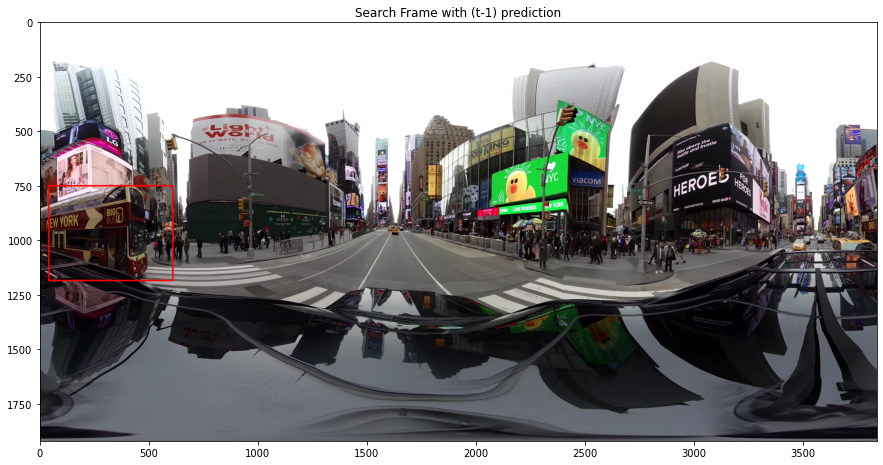

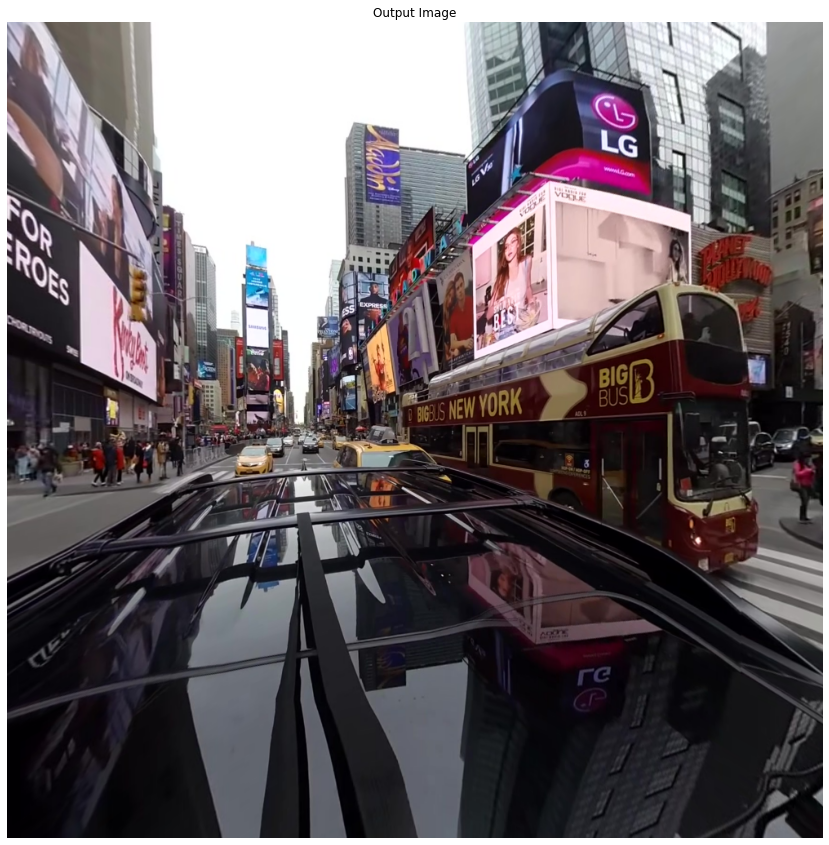

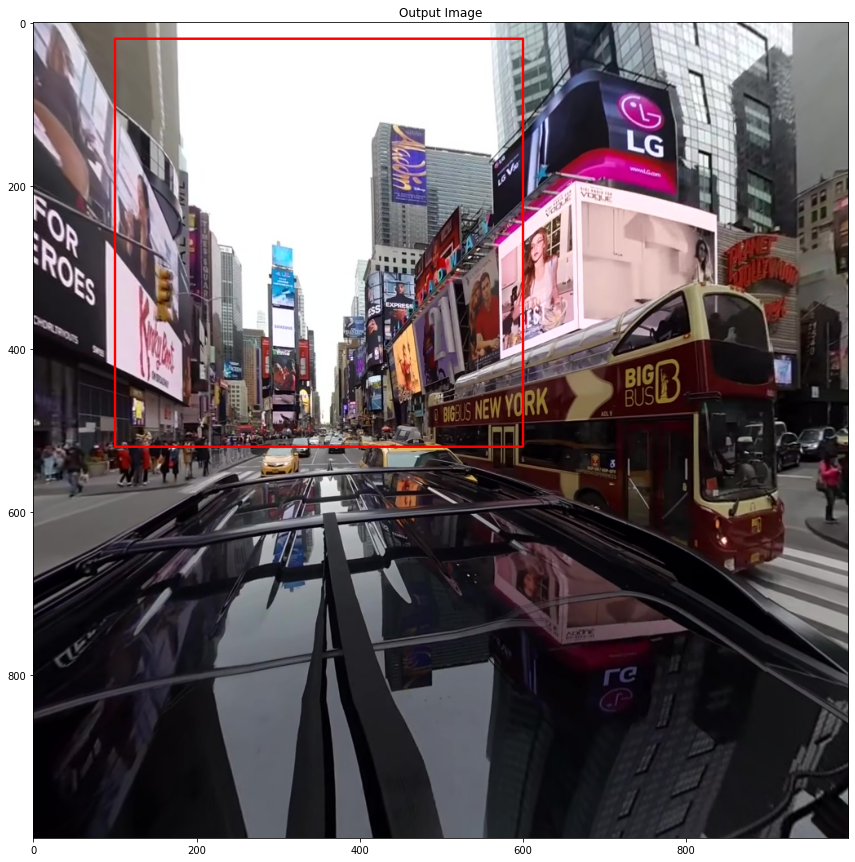

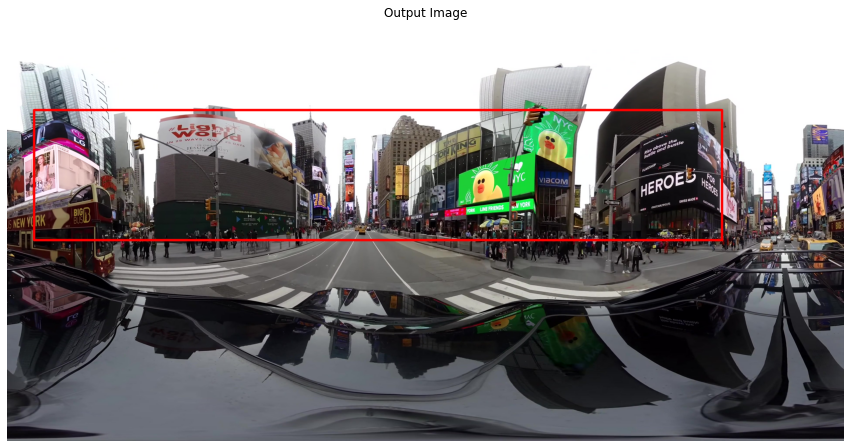

In [7]:
def clip_box(box: list, img_shape, margin=0):
    H, W = img_shape
    x1, y1, w, h = box
    x2 = x1 + w
    y2 = y1 + h

    x1 = min(max(0, x1), W - margin)
    x2 = min(max(margin, x2), W)
    y1 = min(max(0, y1), H - margin)
    y2 = min(max(margin, y2), H)

    w = max(margin, x2 - x1)
    h = max(margin, y2 - y1)
    print(x, y, w, h)
    return [x1, y1, w, h]

class TangentialProjector:
    def __init__(self, erp_img: np.ndarray, bbox_coords: Tuple[int, int, int, int], FOV: float = 90, search_area_factor = 2, output_size: Tuple[int, int] = 1000, direction='centre'):
        self.FOV = FOV
        self.output_size = (output_size, output_size)
        self.erp = erp_img
        self.erp_height, self.erp_width, _ = self.erp.shape
        self.search_area_factor = search_area_factor
        self.bbox_coords = bbox_coords
        self.yaw_radian, self.pitch_radian = self._calculate_projection_params(direction=direction)
         
    def _calculate_bbox_center(self) -> Tuple[int, int]:
        x, y, w, h = self.bbox_coords
        cx = x + w / 2
        cy = y + h / 2
        return int(cx), int(cy)

    def _calculate_projection_params(self, direction='centre') -> Tuple[float, float]:
        cx, cy = self._calculate_bbox_center()
        x, y, w, h = self.bbox_coords
        print(direction)

        adjustment_factor = (w*h/ self.erp_width) * 180 

        if direction == 'right':
             rotate_x = 360 * (cx / self.erp_width) - 180 + adjustment_factor
        elif direction == 'left':
             rotate_x = 360 * (cx / self.erp_width) + adjustment_factor
        else:
            rotate_x = 360 * (cx / self.erp_width) - 180 

        rotate_y = (cy / self.erp_height) * 180 
        return np.radians(rotate_x), np.radians(rotate_y)
        

    def _map_to_sphere(self, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = np.arccos(z / norm)
        phi = np.arctan2(y, x)

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        sin_pitch = np.sin(self.pitch_radian)
        cos_pitch = np.cos(self.pitch_radian)

        theta_prime = np.arccos(sin_theta * sin_phi * sin_pitch + cos_theta * cos_pitch)
        phi_prime = np.arctan2(sin_theta * sin_phi * cos_pitch - cos_theta * sin_pitch, sin_theta * cos_phi)
        phi_prime = (phi_prime + self.yaw_radian) % (2 * np.pi)

        return theta_prime, phi_prime

    def _interpolate_color(self, coords: np.ndarray, method: str = 'bilinear') -> np.ndarray:
        order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
        channels = [map_coordinates(self.erp[:, :, c], coords, order=order, mode='reflect') for c in range(3)]
        return np.stack(channels, axis=-1)

    def project(self) -> np.ndarray:
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)

        u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
        x = u - W / 2
        y = H / 2 - v
        z = f

        theta, phi = self._map_to_sphere(x, y, z)

        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi

        U, V = U.flatten(), V.flatten()
        coords = np.vstack((V, U))

        colors = self._interpolate_color(coords)
        output_image = colors.reshape((H, W, 3)).astype('uint8')

        return output_image

    def _plane_to_sphere(self, u: np.ndarray, v: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)
        x = u - W / 2
        y = H / 2 - v
        z = f
        return self._map_to_sphere(x, y, z)

    def _sphere_to_panorama(self, theta: np.ndarray, phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi
        return U, V

    def inverse_project(self, plane_coords: np.ndarray) -> np.ndarray:
        u, v = plane_coords.T
        theta, phi = self._plane_to_sphere(u, v)
        U, V = self._sphere_to_panorama(theta, phi)
        return np.vstack((U, V)).T
    

# Usage example
bbox_coords = [40, 750,  569, 434]
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0018/image/000602.jpg'
erp_image = cv2.cvtColor(cv2.imread(erp_image_path), cv2.COLOR_BGR2RGB)
height, width, _ = erp_image.shape
erp_with_bbox = draw_bbox(erp_image, bbox_coords, thickness=5)

direction='centre'
proximity_dict = is_box_near_edges(bbox_coords, width, height, threshold=50)
if proximity_dict:
    if proximity_dict['near_left']:
            direction = 'left'
    elif proximity_dict['near_right']:
            direction = 'right'


# Create the PanoramaProjector object
projector = TangentialProjector(erp_image, bbox_coords, FOV=110, direction=direction)

start = time.time()
# Generate the plane image from the panorama
output_image = projector.project()

# Example bounding box coordinates detected in the Tangential Projection Crop
x, y, w, h = [100, 20, 500, 500]  # Example coordinates (x, y, w, h)

# u_coords, v_coords = np.meshgrid(np.arange(x, x + w + 1), np.arange(y, y + h + 1))
# plane_coords = np.vstack((u_coords.ravel(), v_coords.ravel())).T
corners = np.array([
    [x, y],        # top-left
    [x + w, y],    # top-right
    [x, y + h],    # bottom-left
    [x + w, y + h] # bottom-right
])

# Perform inverse projection for all points in the bounding box
erp_remapped = erp_image.copy()
pano_coords = projector.inverse_project(corners)

pano_coords_min = np.min(pano_coords, axis=0)
pano_coords_max = np.max(pano_coords, axis=0)


predictions_on_erp = [pano_coords_min[0], pano_coords_min[1], pano_coords_max[0] - pano_coords_min[0], pano_coords_max[1] - pano_coords_min[1]]
erp_remapped_with_bbox = draw_bbox(erp_image, predictions_on_erp, thickness=10)
end = time.time()
print(f"The projection and its inverse took {end-start:.2f} seconds to complete.")

plt.figure(figsize=(15, 15))
plt.imshow(erp_with_bbox)
plt.title('Search Frame with (t-1) prediction')
plt.show()



plt.figure(figsize=(15, 15))
plt.imshow(output_image)
plt.title('Output Image')
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 15))
plt.imshow(draw_bbox(output_image, [x, y, w, h], thickness=2))
plt.title('Output Image')
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(erp_remapped_with_bbox)
plt.title('Output Image')
plt.axis('off')
plt.show()
